# Study of the Swiss electrical mix (and imports) between 2016 and 2021

This notebook is a study of the Swiss electrical mix (production and imports) between 2016 and 2021. It aims to represent the repartition of the consumed electricity and the associated ghg emissions.
It illustrates some possible uses of EcoDynElec.

We perform a historical analysis of the Swiss energy mix over 5 years, between 2016 and 2021. We have hourly European electricity production and exchange data, from which we calculate the Swiss electricity mix and its carbon impact (in grams of CO2 per kWh).
We mainly use two information types:
- The **producer mix** refers to the electricity produced in the designated country. It contains only local sources. When converting the producer mix into kWh, we obtain the **electricity production** of the country.
- The **consumer mix** refers to the electricity consumed in the designated country. It contains local sources as well as the import of electricity from other countries. When converting the consumer mix into kWh, we obtain the **electricity consumption** of the country.

These data make it possible to calculate the **carbon impact hour by hour** of the electricity produced and consumed in the country (these two impacts are therefore different), and then to study the sources of these emissions.

## 0. Configuring EcoDynElec and loading the data

In [1]:
# Autoreload imports
%load_ext autoreload
%autoreload 2

# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ecodynelec.parameter import Parameter  # Import the class to manipulate parameters
from examples.mix_analysis.analysis_functions import format_data_0, get_metrics, plot_hourly_heatmap, plot_years, \
    plot_typical_days

In [2]:
# EcoDynElec configuration
my_config = Parameter()
my_config.freq = "H"
my_config.ctry = ['AT', 'CH', 'DE', 'FR', 'IT']
my_config.target = ['CH']  # You can put multiple targets here
# Enable this if you want to plot fig 6 (will impact the computation time - it took me 15min)
#my_config.target = ['CH', 'AT', 'FR', 'DE']
my_config.data_cleaning = True
my_config.sg_imports = True
my_config.path.generation = "./mix_analysis/downloads/generations/"
my_config.path.exchanges = "./mix_analysis/downloads/exchanges/"
my_config.path.generation = "../etude_stat/test_data/downloads/generations/"
my_config.path.exchanges = "../etude_stat/test_data/downloads/exchanges/"
# Recommended config: include swiss grid residual (difference between swiss grid and entso-e data)
my_config.residual_global = True
# Recommended config: include real (2020-2022) and estimated (2016-2019) renewable production (using EcoDynElec-Enr-Model)
my_config.ch_enr_model_path = '../support_files/enr_prod_2016-2022_completed.csv'

# Years to study
years = ['2016', '2017', '2018', '2019', '2020', '2021', '2022']

#### 0.1 Download and generate data files
This can done once, then the electrical mix and impact files will be saved and can be loaded directly (see 0.2)

In [3]:
# Data downloading configuration
my_config.server.useServer = False
my_config.server.username = 'your entsoe username'
my_config.server.password = 'your entsoe password'

In [4]:
from examples.mix_analysis.analysis_functions import generate_data

# Allows to run this notebook from another notebook without generating the data again (using %run)
if 'skip_generation' not in globals():
    flows, prods, mixs, prod_impacts, impacts = generate_data(my_config, years,
                                                              savedir="./mix_analysis/results_local_all_enr/")
else:
    print("Skipping data generation")

#### 0.2 Load data from saved files
If the files for the years of interest have already been generated, they can be loaded directly in this section

In [4]:
from examples.mix_analysis.analysis_functions import load_data

flows, prods, mixs, prod_impacts, impacts = load_data(my_config, years,
                                                      savedir="../examples/mix_analysis/results_local_no_enr/")

### 0.3 Pre-processing the data
Here we reformat the data to make it easier to manipulate and plot

In [5]:
from ecodynelec.pipeline_functions import get_producing_mix_kwh, get_consuming_mix_kwh

# NOTE: Unless you use multiple targets (see section 0.), these dicts will contain only one element, corresponding to the target country

raw_productions_by_src = {}
# Dict of dicts containing for each target country:
# 'raw_df': Productions in MWh for each power source in each country, contributing to the target
# 'df': Total consumption in the target country (column 'sum') and contribution of each country (MWh)
raw_consumptions_by_src = {}
electricity_prod_mixs = {}
# Dict of dicts containing for each target country:
# 'raw_df': Shares of each power source in the total mix of the target country (0-1)
# 'df': Shares of each country in the total mix of the target country (0-1)
electricity_mixs = {}
# Dict of dicts containing for each target country:
# 'raw_df': Share of ghg emissions of each power source (gCO2eq from this source for one kWh consumed in the target country). This is **not** the ghg emissions for one kWh produced by this source.
# 'df': Ghg emissions in gCO2eq/kWh of the target country consumption mix (column 'sum') and contribution of each country in this mix (gCO2eq for one kWh consumed in the target country)
electricity_impacts = {}
# Dict of dataframes containing for each country the ghg emissions of one kWh produced in that country (gCO2eq/kWh) (it's the impact of the producing mix of each country)
producing_electricity_impacts = {}

raw_prods = {}
# Temporary dict matching raw_consumptions_by_src['raw_df'] but by year
raw_cons = {}
# Multi-target: correctly extract the data for each target country
if len(my_config.target) > 1:
    for c in my_config.target:
        for y in years:
            raw_prods[y] = {}
            raw_prods[y][c] = get_producing_mix_kwh(flows_df=flows[y][c], prod_mix_df=prods[y][c])
            raw_cons[y] = {}
            raw_cons[y][c] = get_consuming_mix_kwh(flows_df=flows[y][c], mix_df=mixs[y][c])
            # todo et la conso ?
            # todo don't use mix_to_kwh
        raw_productions_by_src[c] = format_data_0({y: raw_prods[y][c] for y in years})
        raw_consumptions_by_src[c] = format_data_0({y: raw_cons[y][c] for y in years})
        electricity_prod_mixs[c] = format_data_0({y: prods[y][c] for y in years})
        electricity_mixs[c] = format_data_0({y: mixs[y][c] for y in years})
        electricity_impact = format_data_0({y: impacts[y][c] for y in years})
        producing_electricity_impact = format_data_0({y: prod_impacts[y][c] for y in years})
        # old producing_electricity_impact = electricity_impact['df'][c] / electricity_mixs[c]['df'][c]
        # convert kgCO2eq/kWh -> gCO2eq/kWh
        electricity_impacts[c] = {k: v * 1000 for k, v in electricity_impact.items()}
        producing_electricity_impacts[c] = {k: v * 1000 for k, v in producing_electricity_impact.items()}
        # old producing_electricity_impacts[c] = producing_electricity_impact * 1000

    # Extract the data for CH
    raw_production_by_src = raw_productions_by_src['CH']
    raw_consumption_by_src = raw_consumptions_by_src['CH']
    electricity_prod_mix = electricity_prod_mixs['CH']
    electricity_mix = electricity_mixs['CH']
    electricity_impact = electricity_impacts['CH']
    producing_electricity_impact = producing_electricity_impacts['CH']  #pd.DataFrame(producing_electricity_impacts)
else:  # Easy case: only one target country (not that figure 6 and table 4 will not be available)
    for y in years:
        raw_prods[y] = get_producing_mix_kwh(flows_df=flows[y], prod_mix_df=prods[y])
        raw_cons[y] = get_consuming_mix_kwh(flows_df=flows[y], mix_df=mixs[y])
    raw_production_by_src = format_data_0({y: raw_prods[y] for y in years})
    raw_consumption_by_src = format_data_0({y: raw_cons[y] for y in years})
    electricity_prod_mix = format_data_0({y: prods[y] for y in years})
    electricity_mix = format_data_0({y: mixs[y] for y in years})
    electricity_impact = format_data_0({y: impacts[y] for y in years})
    producing_electricity_impact = format_data_0({y: prod_impacts[y] for y in years})
    # old producing_electricity_impact = electricity_impact['df'] / electricity_mix['df']
    # convert kgCO2eq/kWh -> gCO2eq/kWh
    electricity_impact = {k: v * 1000 for k, v in electricity_impact.items()}
    producing_electricity_impact = {k: v * 1000 for k, v in producing_electricity_impact.items()}
    # old producing_electricity_impact = producing_electricity_impact * 1000
del raw_prods, raw_cons

Over total kwh 2016-01-01 00:00:00     4728.12207
2016-01-01 01:00:00    4586.255859
2016-01-01 02:00:00    4558.943848
2016-01-01 03:00:00    4495.620117
2016-01-01 04:00:00    4536.367188
                          ...     
2016-12-31 19:00:00     4581.59082
2016-12-31 20:00:00    4903.441895
2016-12-31 21:00:00    3944.218994
2016-12-31 22:00:00     4129.00293
2016-12-31 23:00:00    4283.155273
Name: production, Length: 8784, dtype: object
Over total kwh 2016-01-01 00:00:00    6924.753418
2016-01-01 01:00:00    7033.930908
2016-01-01 02:00:00    6923.001709
2016-01-01 03:00:00    6675.741455
2016-01-01 04:00:00    6625.919189
                          ...     
2016-12-31 19:00:00    7322.658936
2016-12-31 20:00:00     7072.26123
2016-12-31 21:00:00    7137.636963
2016-12-31 22:00:00    7139.991943
2016-12-31 23:00:00    7094.396729
Length: 8784, dtype: object
Over total kwh 2017-01-01 00:00:00    4214.980957
2017-01-01 01:00:00    3845.390137
2017-01-01 02:00:00    3723.583008
2017-0

### 0.4 Plots configuration

Some color codes for each country

In [6]:
ordered_countries = ['CH', 'DE', 'FR', 'AT', 'IT', 'Other']
colormap = {
    'sum': 'gray',
    'CH': '#1f77b4',
    'DE': '#c62728',
    'FR': '#2ca02c',
    'IT': '#9467bd',
    'AT': '#ff7f0e',
    'Other': '#e377c2'
}
colormap_extended = colormap | {
    'Nuclear_CH': '#8c564b',
    'Residual_Hydro_Run-of-river_and_poundage_CH': '#000080',  # Couleur bleu marine
    'Residual_Hydro_Water_Reservoir_CH': '#004090',  # Couleur bleu marine
    'Hydro_Water_Reservoir_CH': '#98df8a',
    'Residual_Other_CH': '#ffbb78',
    'Hydro_Pumped_Storage_CH': '#bcbd22',
    'Hydro_Run-of-river_and_poundage_CH': '#17becf',
    'Solar_CH': '#d62728',
    'Other_CH': '#1f77b4'
}
ordered_colors = [colormap[c] for c in ordered_countries]

## 1. Inter-annual analysis

Swiss annual electricity consumption

In [12]:
yearly_cons = raw_consumption_by_src['raw_df'].resample('Y').sum().sum(axis=1).map(lambda x: f'{x / 1000:.2f} GWh')
yearly_cons.index = pd.Series(years)
print('Consumption:')
print(yearly_cons)

yearly_prod = raw_production_by_src['raw_df'].resample('Y').sum().sum(axis=1).map(lambda x: f'{x / 1000:.2f} GWh')
yearly_prod.index = pd.Series(years)
print('Production:')
print(yearly_prod)

Consumption:
2016    63369.65 GWh
2017    64457.44 GWh
2018    63657.23 GWh
2019    63477.59 GWh
2020    62453.90 GWh
2021    64459.43 GWh
2022    64714.66 GWh
dtype: object
Production:
2016    58955.51 GWh
2017    58415.07 GWh
2018    64931.10 GWh
2019    69351.62 GWh
2020    67651.79 GWh
2021    61563.38 GWh
2022    60789.18 GWh
dtype: object


Monthly electricity consumption in 2021

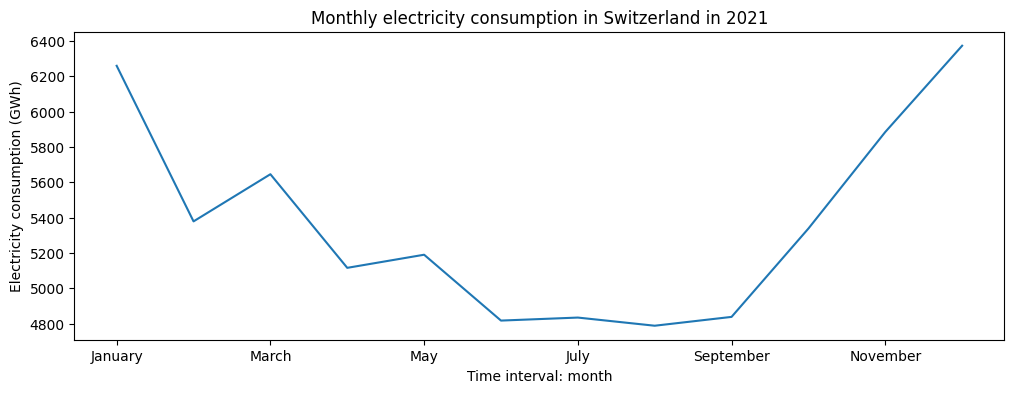

In [13]:
monthly_cons = raw_consumption_by_src['raw_df']
monthly_cons = monthly_cons.loc[[d.year == 2021 for d in monthly_cons.index]]
monthly_cons = monthly_cons.resample('M').sum().sum(axis=1).map(
    lambda x: x / 1000)  #.map(lambda x: f'{x / 1000:.2f} GWh')
monthly_cons.index = [f'{d.month_name()}' for d in monthly_cons.index]
#print(monthly_prod)
monthly_cons.plot(figsize=(12, 4), title='Monthly electricity consumption in Switzerland in 2021')
plt.xlabel('Time interval: month')
plt.ylabel('Electricity consumption (GWh)');

2021 Monthly production from selected sources (helps to validate the data)

In [14]:
ch_prod_raw = {}
# Multi-target: correctly extract the data for each target country
if len(my_config.target) > 1:
    for y in years:
        #ch_prod_raw[y] = mix_to_kwh(my_config, flows_df=flows[y]['CH'], mix_df=prods[y]['CH'], target='CH', return_data='+P')
        ch_prod_raw[y] = get_producing_mix_kwh(flows_df=flows[y]['CH'], prod_mix_df=prods[y]['CH'])
else:
    for y in years:
        #ch_prod_raw[y] = mix_to_kwh(my_config, flows_df=flows[y], mix_df=prods[y], target='CH', return_data='+P')
        ch_prod_raw[y] = get_producing_mix_kwh(flows_df=flows[y], prod_mix_df=prods[y])
ch_prod_raw = format_data_0({y: ch_prod_raw[y] for y in years})['raw_df']
cols = ['Solar_CH', 'Nuclear_CH',
        'Wind_Onshore_CH']  # ['Residual_Hydro_Water_Reservoir_CH', 'Residual_Hydro_Run-of-river_and_poundage_CH', 'Residual_Other_CH'] ...
start = '2020-01-01'
end = '2020-12-31'
monthly_prod = ch_prod_raw[cols][start:end].resample('M').sum()
del ch_prod_raw
monthly_prod / 1000

Over total kwh 2016-01-01 00:00:00    4728.122070
2016-01-01 01:00:00    4586.255859
2016-01-01 02:00:00    4558.943848
2016-01-01 03:00:00    4495.620117
2016-01-01 04:00:00    4536.367188
                          ...     
2016-12-31 19:00:00    4581.590820
2016-12-31 20:00:00    4903.441895
2016-12-31 21:00:00    3944.218994
2016-12-31 22:00:00    4129.002930
2016-12-31 23:00:00    4283.155273
Name: production, Length: 8784, dtype: float64
Over total kwh 2017-01-01 00:00:00    4214.980957
2017-01-01 01:00:00    3845.390137
2017-01-01 02:00:00    3723.583008
2017-01-01 03:00:00    3578.000977
2017-01-01 04:00:00    3478.807129
                          ...     
2017-12-31 19:00:00    5434.246094
2017-12-31 20:00:00    5320.895020
2017-12-31 21:00:00    5230.952148
2017-12-31 22:00:00    5215.794922
2017-12-31 23:00:00    5119.281738
Name: production, Length: 8760, dtype: float64
Over total kwh 2018-01-01 00:00:00    5159.791016
2018-01-01 01:00:00    5184.075195
2018-01-01 02:00:00  

,Solar_CH,Nuclear_CH,Wind_Onshore_CH
2020-01-31,86.611093,2231.406005,15.631811
2020-02-29,118.939483,2086.506991,24.123696
2020-03-31,224.359136,2230.835794,15.891792
2020-04-30,328.650168,2016.933200,7.161390
2020-05-31,353.635168,1988.290504,9.613277
2020-06-30,314.263125,1500.136600,8.150604
2020-07-31,366.099839,1245.160101,7.130528
2020-08-31,303.704767,1654.972099,7.124174
2020-09-30,240.506252,2103.930687,7.850673
2020-10-31,139.187922,2195.279296,15.270487


Main power sources in the Swiss electricity mix

In [15]:
yearly_mix = electricity_mix['raw_df'].resample('Y').mean()
local_cols = yearly_mix.mean().nlargest(20).index.tolist()
yearly_mix = yearly_mix.applymap(lambda x: f'{x * 100:.0f} %')
yearly_mix.index = pd.Series(years)
print(yearly_mix[local_cols])

     Nuclear_CH Residual_Hydro_Run-of-river_and_poundage_CH   
2016       21 %                                        16 %  \
2017       21 %                                        15 %   
2018       26 %                                        15 %   
2019       27 %                                        15 %   
2020       25 %                                        17 %   
2021       20 %                                        15 %   
2022       26 %                                        12 %   

     Hydro_Water_Reservoir_CH Hydro_Pumped_Storage_CH Nuclear_FR   
2016                      8 %                     5 %        7 %  \
2017                      9 %                     6 %        7 %   
2018                     10 %                     7 %        6 %   
2019                     12 %                     7 %        7 %   
2020                     12 %                     7 %        6 %   
2021                     11 %                     7 %        7 %   
2022               

Consumed electricity by country of origin and associated GHG emissions

In [16]:
producing_electricity_impact

{'raw_df':                      Residual_Hydro_Water_Reservoir_CH   
 2016-01-01 00:00:00                           0.258458  \
 2016-01-01 01:00:00                           0.259386   
 2016-01-01 02:00:00                           0.251014   
 2016-01-01 03:00:00                           0.258624   
 2016-01-01 04:00:00                           0.270141   
 ...                                                ...   
 2022-12-31 19:00:00                           0.246121   
 2022-12-31 20:00:00                           0.231638   
 2022-12-31 21:00:00                           0.225428   
 2022-12-31 22:00:00                           0.214553   
 2022-12-31 23:00:00                                NaN   
 
                      Residual_Hydro_Run-of-river_and_poundage_CH   
 2016-01-01 00:00:00                                     0.171126  \
 2016-01-01 01:00:00                                     0.171740   
 2016-01-01 02:00:00                                     0.166197   
 201

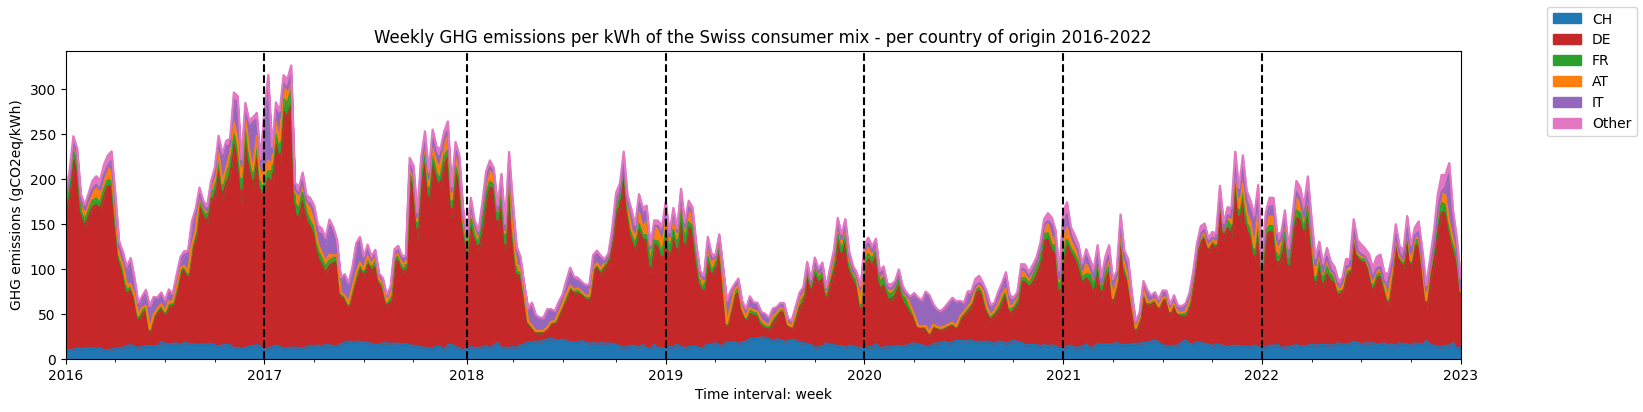

In [61]:
fig, ax1 = plt.subplots(1, 1, figsize=(18, 4))
ax1.set_title("Weekly GHG emissions per kWh of the Swiss consumer mix - per country of origin 2016-2022")
impc = electricity_impact['df'].drop(['sum'], axis=1)
impc = impc.resample('W').mean()
impc[ordered_countries].plot.area(ax=ax1, color=ordered_colors, legend=False)
ax1.set_xlabel('Time interval: week')
ax1.set_ylabel('GHG emissions (gCO2eq/kWh)')

plot_years()

fig.legend();
# fig.legend(np.concatenate([ax1.get_lines(), ax2.get_lines()]),
#            np.concatenate([ax1.get_legend_handles_labels()[1],
#                            ['CH consumer mix (GHG emissions)', 'DE production mix (GHG emissions)']]),
#            loc='upper left', ncol=4, bbox_to_anchor=(0.1, 0));

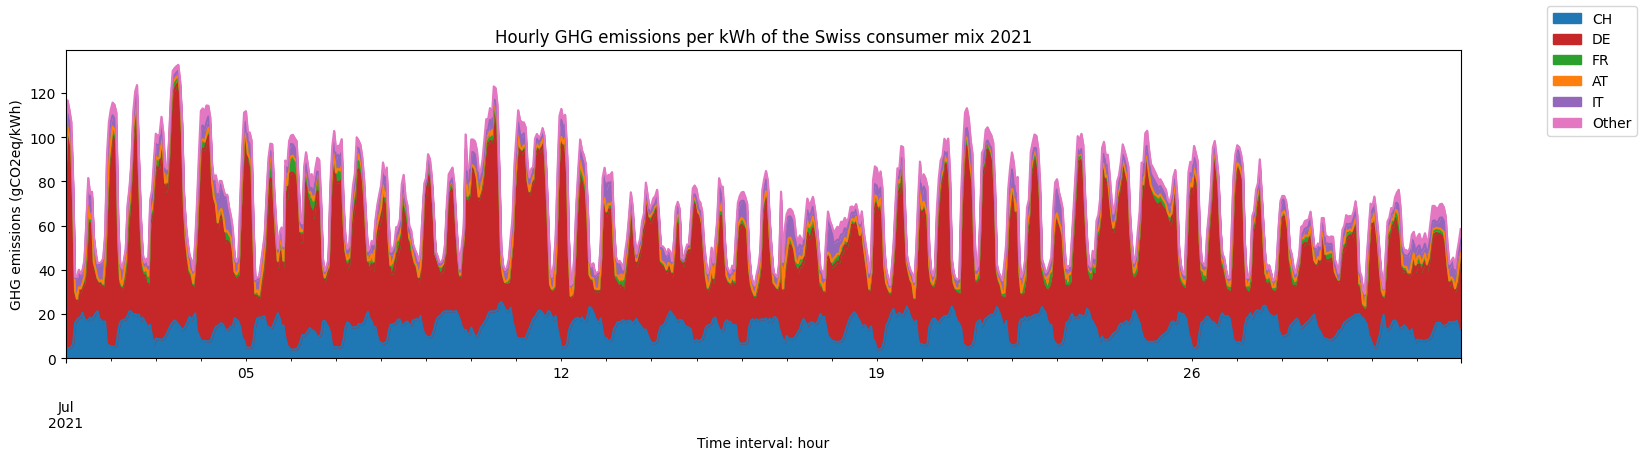

In [59]:
fig, ax1 = plt.subplots(1, 1, figsize=(18, 4))
ax1.set_title("Hourly GHG emissions per kWh of the Swiss consumer mix 2021")
impc = electricity_impact['df'].drop(['sum'], axis=1)
impc = impc.loc['07-2021']
impc[ordered_countries].plot.area(ax=ax1, color=ordered_colors, legend=False)
ax1.set_xlabel('Time interval: hour')
ax1.set_ylabel('GHG emissions (gCO2eq/kWh)')

fig.legend();
# fig.legend(np.concatenate([ax1.get_lines(), ax2.get_lines()]),
#            np.concatenate([ax1.get_legend_handles_labels()[1],
#                            ['CH consumer mix (GHG emissions)', 'DE production mix (GHG emissions)']]),
#            loc='upper left', ncol=4, bbox_to_anchor=(0.1, 0));

In [15]:
def compute_per_type(results):
    """Function to group datasets per type of unit, regardless of the country of origin"""
    unit_list = np.unique(
        [k[:-3] if k[-3] == "_" else k for k in results.columns])  # List the different production units

    per_unit = []
    for u in unit_list:
        cols = [k for k in results.columns if k[:-3] == u]  # collect the useful columns
        per_unit.append(pd.Series(results.loc[:, cols].sum(axis=1), name=u))  # aggregate

    return pd.concat(per_unit, axis=1)

In [18]:
electricity_impact['raw_df'][electricity_impact['raw_df'] < 0] = 0

In [54]:
imp = electricity_impact['raw_df'].loc['2021'].resample('D').mean()

C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_10176\1598088887.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  es13_per_type_10['Other sources'] = es13_per_type.sum(axis=1) - es13_per_type_10.sum(axis=1)


Text(0, 0.5, 'GHG emissions (gCO2eq/kWh)')

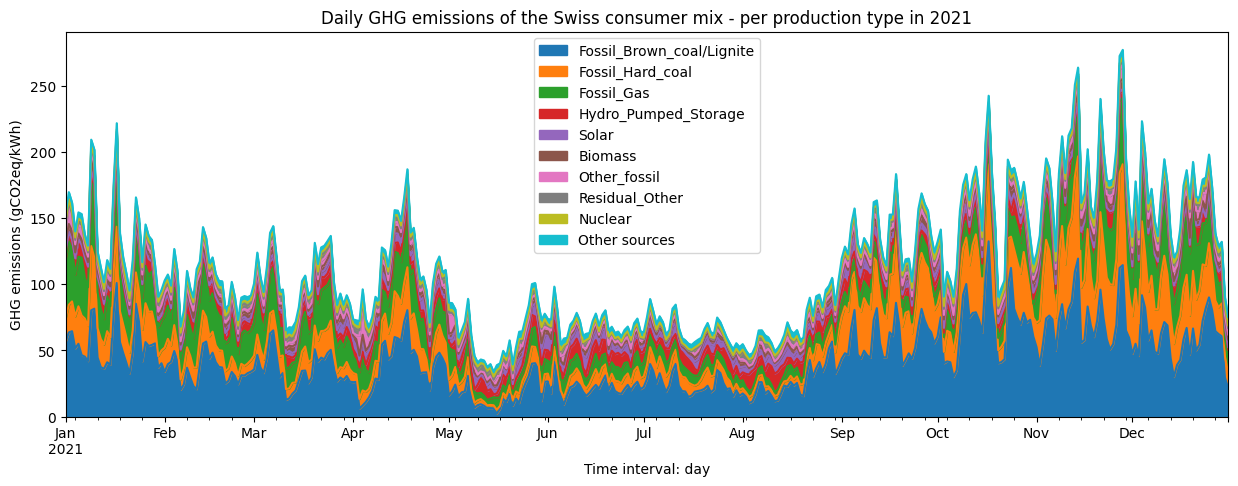

In [57]:
es13_per_type = compute_per_type(imp)  # Group Climate Change index impacts per country
local_cols = es13_per_type.mean().nlargest(9).index.tolist()
es13_per_type_10 = es13_per_type[local_cols]
es13_per_type_10['Other sources'] = es13_per_type.sum(axis=1) - es13_per_type_10.sum(axis=1)
es13_per_type_10.plot.area(figsize=(15, 5),
                           title="Daily GHG emissions of the Swiss consumer mix - per production type in 2021")  # Build the graph

#ch_consumer_impact = (electricity_impact['df']['sum']).loc['2021'].resample('W').mean()  # convert kgCO2eq/kWh -> gCO2eq/kWh
#ch_consumer_impact.plot(linestyle='-', color=[colormap['sum']])

plt.xlabel('Time interval: day')
plt.ylabel('GHG emissions (gCO2eq/kWh)')
#plt.legend(['CH consumer mix (GHG emissions)'] + es13_per_type.columns.tolist(), loc='upper left', ncol=4, bbox_to_anchor=(0.1, 0));

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(18, 4))
ax1.set_title("Hourly GHG emissions per kWh of the Swiss consumer mix 2021")
impc = electricity_impact['df'].drop(['sum'], axis=1)
impc = impc.loc['2021']
impc[ordered_countries].plot.area(ax=ax1, color=ordered_colors, legend=False)
ax1.set_xlabel('Time interval: hour')
ax1.set_ylabel('Hourly average of GHG emissions (gCO2eq/kWh)')

fig.legend();
# fig.legend(np.concatenate([ax1.get_lines(), ax2.get_lines()]),
#            np.concatenate([ax1.get_legend_handles_labels()[1],
#                            ['CH consumer mix (GHG emissions)', 'DE production mix (GHG emissions)']]),
#            loc='upper left', ncol=4, bbox_to_anchor=(0.1, 0));

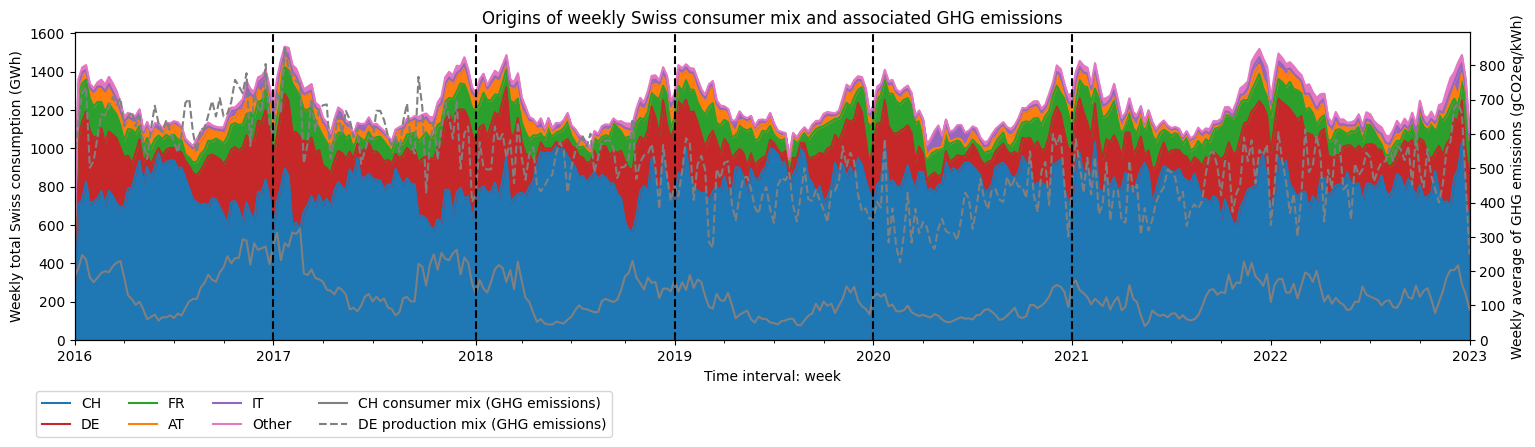

In [17]:
fig, ax1 = plt.subplots(1, 1, figsize=(18, 4))
ax1.set_title("Origins of weekly Swiss consumer mix and associated GHG emissions")
mix_import = electricity_mix['df'].drop(['sum'], axis=1)
mix_import = mix_import.multiply(raw_consumption_by_src['df']['sum'], axis='index').resample('W').sum() / 1000
mix_import[ordered_countries].plot.area(ax=ax1, color=ordered_colors, legend=False)
ax1.set_xlabel('Time interval: week')
ax1.set_ylabel('Weekly total Swiss consumption (GWh)')

ax2 = ax1.twinx()
ch_consumer_impact = (electricity_impact['df']['sum']).resample('W').mean()  # convert kgCO2eq/kWh -> gCO2eq/kWh
ch_consumer_impact.plot(ax=ax2, linestyle='-', color=[colormap['sum']])
de_producing_impact = (producing_electricity_impacts['DE']['df']['sum']).resample(
    'W').mean()  # convert kgCO2eq/kWh -> gCO2eq/kWh
de_producing_impact.plot(ax=ax2, linestyle='--', color=[colormap['sum']])
ax2.set_ylabel('Weekly average of GHG emissions (gCO2eq/kWh)')

plot_years()

fig.legend(np.concatenate([ax1.get_lines(), ax2.get_lines()]),
           np.concatenate([ax1.get_legend_handles_labels()[1],
                           ['CH consumer mix (GHG emissions)', 'DE production mix (GHG emissions)']]),
           loc='upper left', ncol=4, bbox_to_anchor=(0.1, 0));

Mix by source (import source and main CH production sources)

lc cols ['Nuclear_CH', 'Residual_Hydro_Run-of-river_and_poundage_CH', 'Hydro_Water_Reservoir_CH', 'Hydro_Pumped_Storage_CH', 'Residual_Hydro_Water_Reservoir_CH', 'Solar_CH']


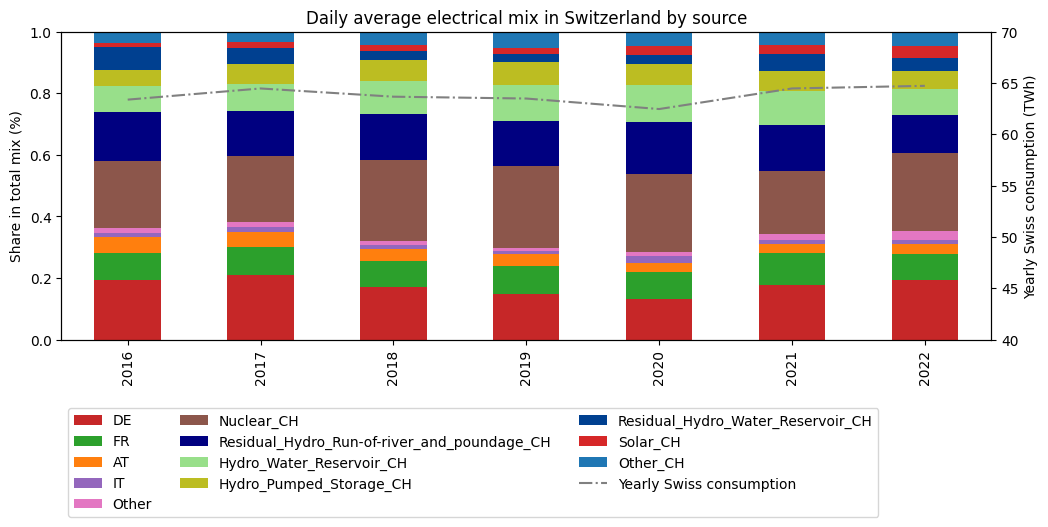

In [18]:
fig, ax = plt.subplots(figsize=(12, 4))

# import mix
compute_mix = electricity_mix['df'][ordered_countries].drop('CH', axis=1)
# local CH mix
local_mix = electricity_mix['raw_df']  # wtf .resample('W').mean()
local_mix = local_mix.drop(local_mix.loc[:, [not k.endswith('CH') or 'Mix' in k for k in local_mix.columns]], axis=1)
local_cols = local_mix.mean().nlargest(len(ordered_countries)).index.tolist()
print('lc cols', local_cols)
local_mix['Other_CH'] = local_mix.drop(local_cols, axis=1).sum(axis=1)
# merged mix
compute_mix = pd.concat([compute_mix, local_mix[local_cols], local_mix['Other_CH']], axis=1)
metric = 'mean'
metric_values = get_metrics(years, compute_mix, [metric], 'Y')
colors = [colormap_extended[c] for c in compute_mix.columns]
# yearly consumption (TWh), used for comparison
yearly_consumption = raw_consumption_by_src['df']['sum'].resample('Y').sum() / 1e6
yearly_consumption.index = metric_values[metric].index  # keep same x axis
# plot
ax2 = ax.twinx()
ax = metric_values[metric].plot.bar(ax=ax, stacked=True, color=colors, legend=True)
yearly_consumption.plot(ax=ax2, linestyle='-.', color='gray', legend=False, label='Yearly Swiss consumption')
ax.set_title(f'Daily average electrical mix in Switzerland by source')
ax.set_label('date')
ax.set_ylabel('Share in total mix (%)')
ax.set_ylim(0, 1)
ax2.set_ylabel('Yearly Swiss consumption (TWh)')
ax2.set_ylim(40, 70)
# Merge legend of both axes
handles, labels = ax.get_legend_handles_labels()
handles.append(ax2.get_lines()[0])
labels.append(ax2.get_legend_handles_labels()[1][0])
ax.legend(handles, labels, ncol=3,
          loc='upper left', bbox_to_anchor=(0, -0.2))

Impact of consumption mix over five years

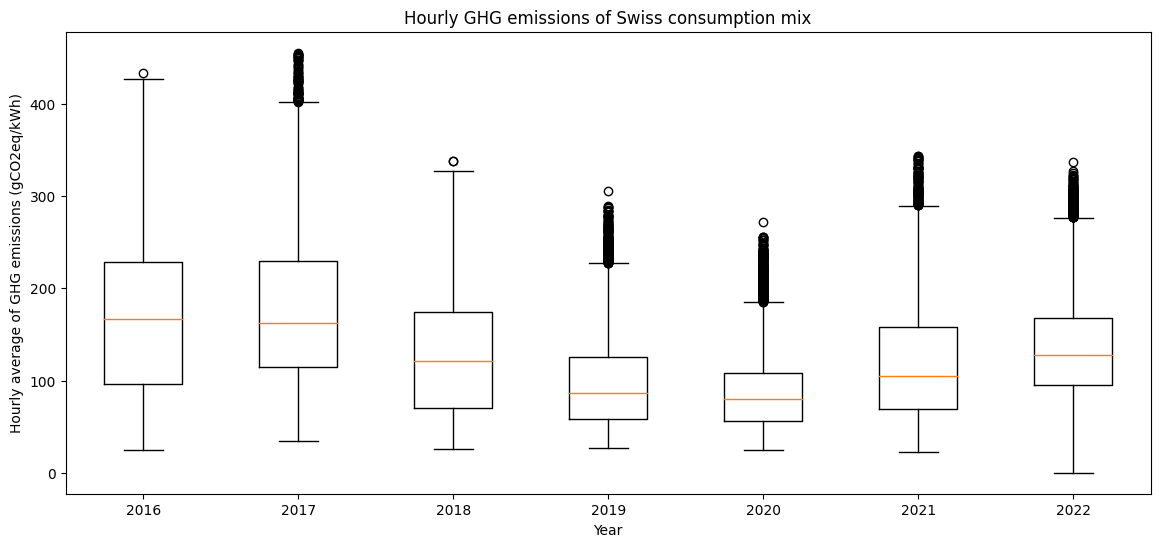

In [19]:
fig, ax = plt.subplots(figsize=(14, 6))
data = electricity_impact['df'].astype('float32')
data = pd.DataFrame(data['sum'])
data['Year'] = [date.year for date in data.index]
grouped_data = data.groupby('Year')
seasonal_data = [grouped_data.get_group(season)[data.columns[0]] for season in grouped_data.groups]
ax.boxplot(seasonal_data)
ax.set_xticklabels(grouped_data.groups.keys())
ax.set_title('Hourly GHG emissions of Swiss consumption mix')
ax.set_xlabel('Year')
ax.set_ylabel('Hourly average of GHG emissions (gCO2eq/kWh)');

Impact of production mix over five years

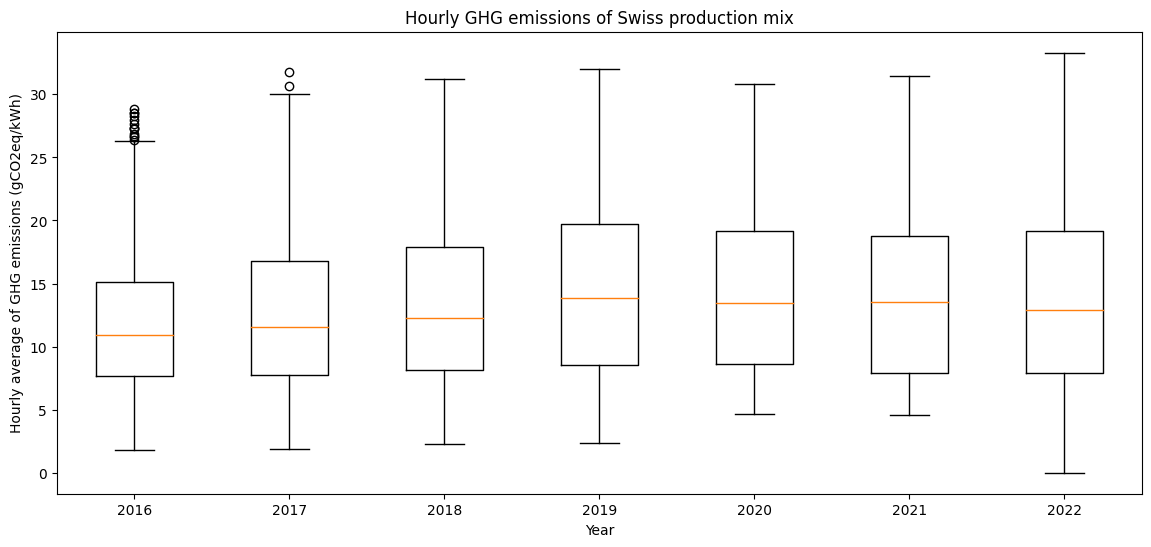

In [20]:
fig, ax = plt.subplots(figsize=(14, 6))
data = producing_electricity_impact['raw_df'].astype('float32')
data = data.drop(data.loc[:, [not k.endswith('CH') or 'Mix' in k for k in data.columns]], axis=1)
data = pd.DataFrame(data.sum(axis=1))
data['Year'] = [date.year for date in data.index]
grouped_data = data.groupby('Year')
seasonal_data = [grouped_data.get_group(season)[data.columns[0]] for season in grouped_data.groups]
ax.boxplot(seasonal_data)
ax.set_xticklabels(grouped_data.groups.keys())
ax.set_title('Hourly GHG emissions of Swiss production mix')
ax.set_xlabel('Year')
ax.set_ylabel('Hourly average of GHG emissions (gCO2eq/kWh)');

Figure 6, comparison between the producing impacts of several countries and the import mix of Switzerland
**Make sure to compute the production mix of *all* the countries before running this cell (enable the corresponding line in section 0)**

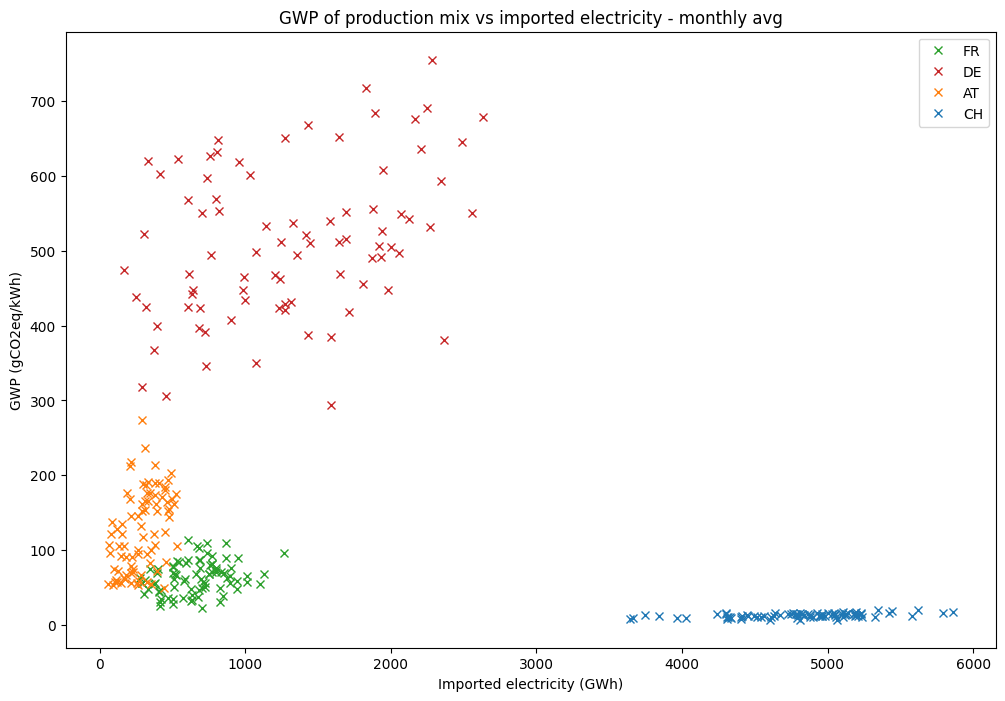

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))
x = np.linspace(0, 1, 100)
countries = ['FR', 'DE', 'AT', 'CH']
for c in countries:
    #mx = electricity_mixs['CH']['df'][c].resample('M').mean()
    mx = raw_consumptions_by_src['CH']['df'][c].resample('M').mean()
    px = producing_electricity_impacts[c]['df']['sum'].resample('M').mean()
    plt.plot(mx, px, color=colormap[c], label=c, marker='x', linestyle='None')
plt.title('GWP of production mix vs imported electricity - monthly avg')
plt.xlabel('Imported electricity (GWh)')
plt.ylabel('GWP (gCO2eq/kWh)')
plt.legend();

Table 4, comparison between the producing impacts of several countries an the impacts of imports in Switzerland
**Make sure to compute the production mix of *all* the countries before running this cell (enable the corresponding line in section 0)**

In [22]:
countries = ['FR', 'DE', 'AT']
table = {}
freq = 'Y'
for c in countries:
    table[c + '_prod'] = producing_electricity_impacts[c]['df']['sum'].resample(freq).mean()
for c in countries:
    emitted_co2 = producing_electricity_impacts[c]['df']['sum'].multiply(raw_consumptions_by_src['CH']['df'][c])
    emitted_co2 = emitted_co2.resample(freq).sum() / raw_consumptions_by_src['CH']['df'][c].resample(freq).sum()
    table[c + '_import'] = emitted_co2
    #table[c + '_import'] = electricity_impact['df'][c].resample(freq).mean()
tabled = pd.DataFrame(table)
for c in countries:
    tabled[c + '_diff'] = (tabled[c + '_import'].astype(float) - tabled[c + '_prod'].astype(float)) / tabled[
        c + '_prod'].astype(float) * 100
tabled = tabled.applymap(lambda val: f'{val:.2f}').T
ordered_table = tabled.loc[
    ['AT_prod', 'AT_import', 'AT_diff', 'FR_prod', 'FR_import', 'FR_diff', 'DE_prod', 'DE_import', 'DE_diff']]
ordered_table.index = ['AT production mix impact', 'Impact of AT electricity consumed in CH', 'Difference (%)',
                       'FR production mix impact', 'Impact of FR electricity consumed in CH', 'Difference (%)',
                       'DE production mix impact', 'Impact of DE electricity consumed in CH', 'Difference (%)']

In [23]:
ordered_table

,2016-12-31,2017-12-31,2018-12-31,2019-12-31,2020-12-31,2021-12-31,2022-12-31
AT production mix impact,127.69,128.64,124.30,129.19,118.51,122.00,126.03
Impact of AT electricity consumed in CH,130.66,135.02,146.42,130.20,117.70,134.53,134.84
Difference (%),2.33,4.97,17.80,0.78,-0.68,10.27,6.99
FR production mix impact,66.77,76.91,55.96,56.50,56.73,56.41,78.09
Impact of FR electricity consumed in CH,69.83,81.35,55.16,52.53,54.08,54.24,76.17
Difference (%),4.58,5.77,-1.44,-7.03,-4.67,-3.86,-2.46
DE production mix impact,647.75,626.07,525.04,438.40,395.47,450.66,499.11
Impact of DE electricity consumed in CH,654.78,626.55,517.89,424.10,374.76,447.48,474.88
Difference (%),1.09,0.08,-1.36,-3.26,-5.24,-0.71,-4.85


## 2. Intra-annual analysis

Heatmaps of :
- CH consumption
- DE and FR imports
- Consumption from hydro production (pumped storage and water reservoir)

The exported electricity is not taken into account in these figures.

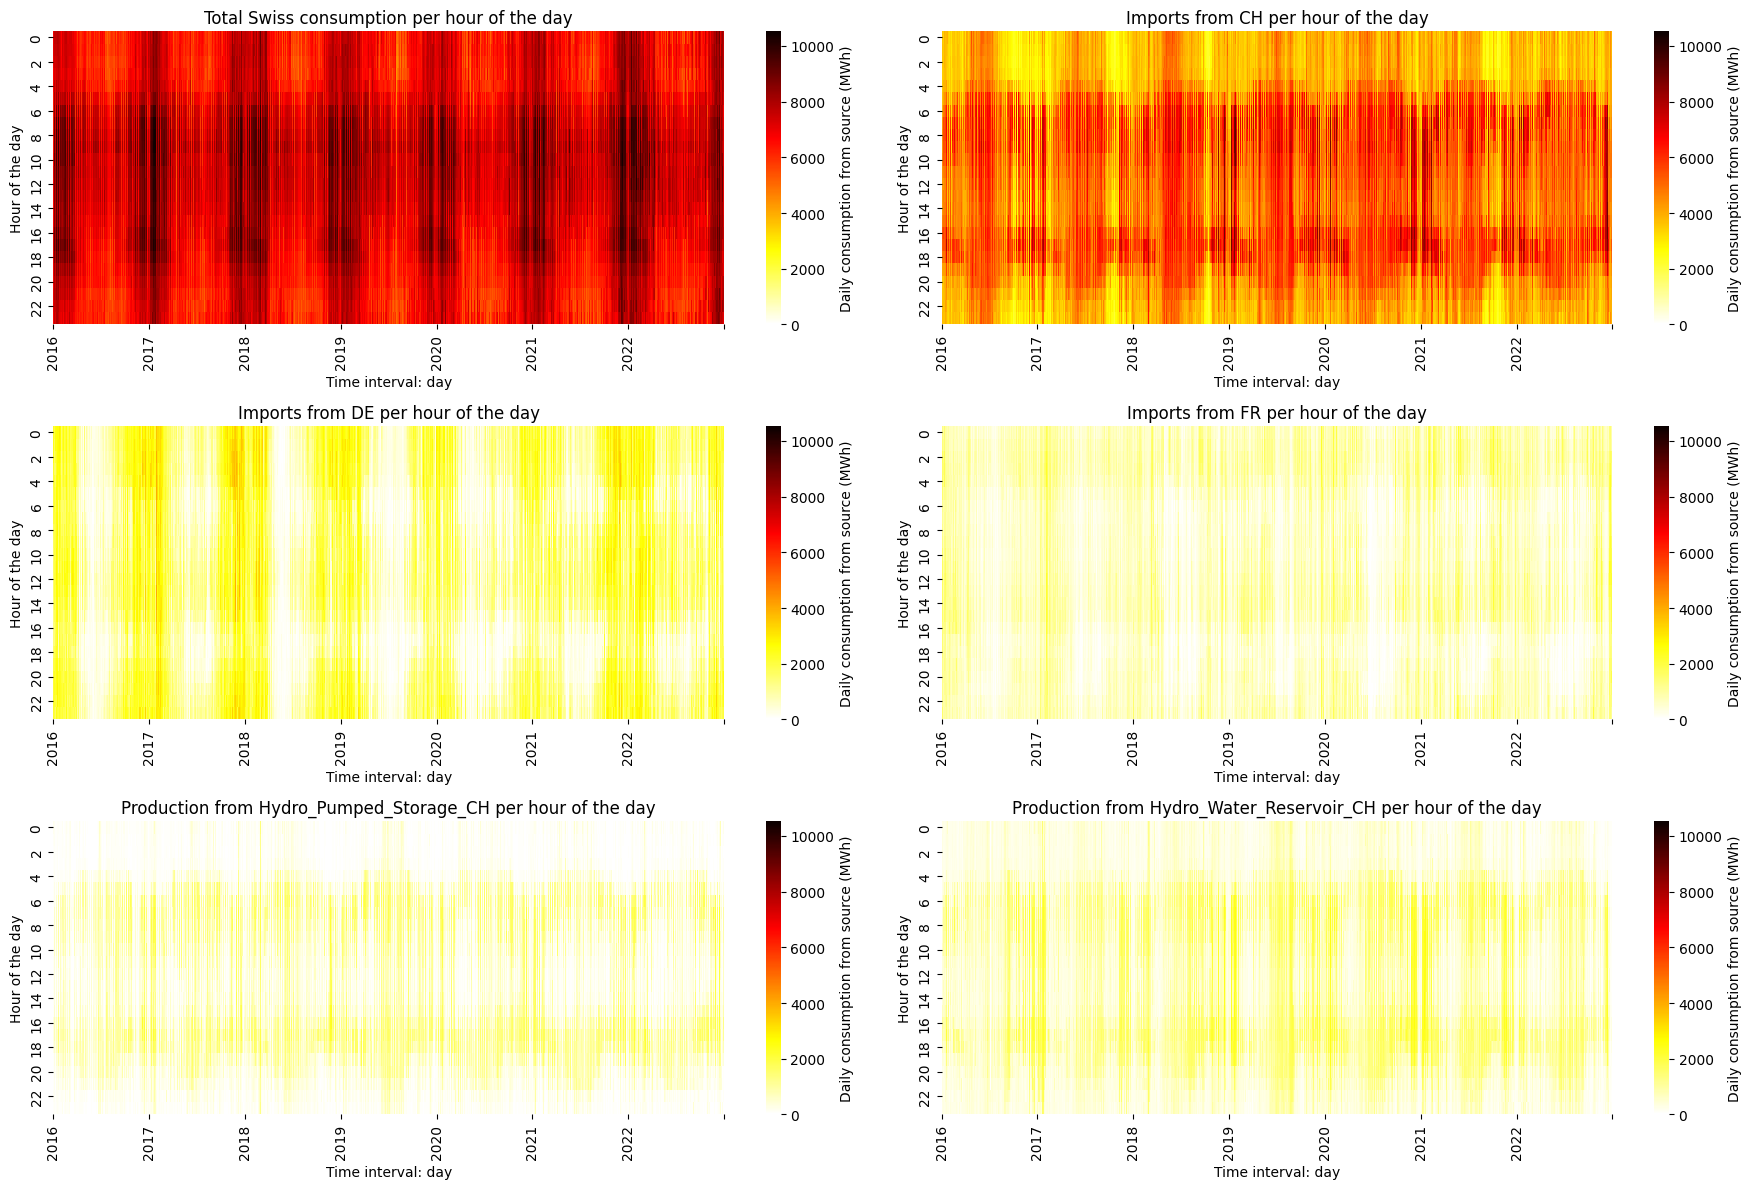

In [24]:
fig, ax = plt.subplots(3, 2, figsize=(18, 12))
countries = ['sum', 'CH', 'DE', 'FR']
# Heatmap import
data = raw_consumption_by_src['df'][countries].copy()
val_max = data[countries].max().max()
for i in range(len(countries)):
    series = data[countries[i]]
    xlabels = list(series.resample('Y').mean().index.map(lambda x: x.year).values)
    plot_hourly_heatmap(data, countries[i], xlabels, 'Imports from ' + countries[i],
                        'Daily consumption from source (MWh)', val_max=val_max, fig=fig, ax=ax[i // 2, i % 2])

ax[0, 0].set_title('Total Swiss consumption per hour of the day')

# Heatmap hydro
cols = ['Hydro_Pumped_Storage_CH', 'Hydro_Water_Reservoir_CH']
data2 = raw_consumption_by_src['raw_df'][cols].astype(float)
for i in range(len(cols)):
    series = data2[cols[i]]
    xlabels = list(series.resample('Y').mean().index.map(lambda x: x.year).values)
    plot_hourly_heatmap(data2, cols[i], xlabels, 'Production from ' + cols[i], 'Daily consumption from source (MWh)',
                        val_max=val_max, fig=fig, ax=ax[2, i])

fig.tight_layout()

Heatmap of the carbon emissions associated to the Swiss consumption mix :

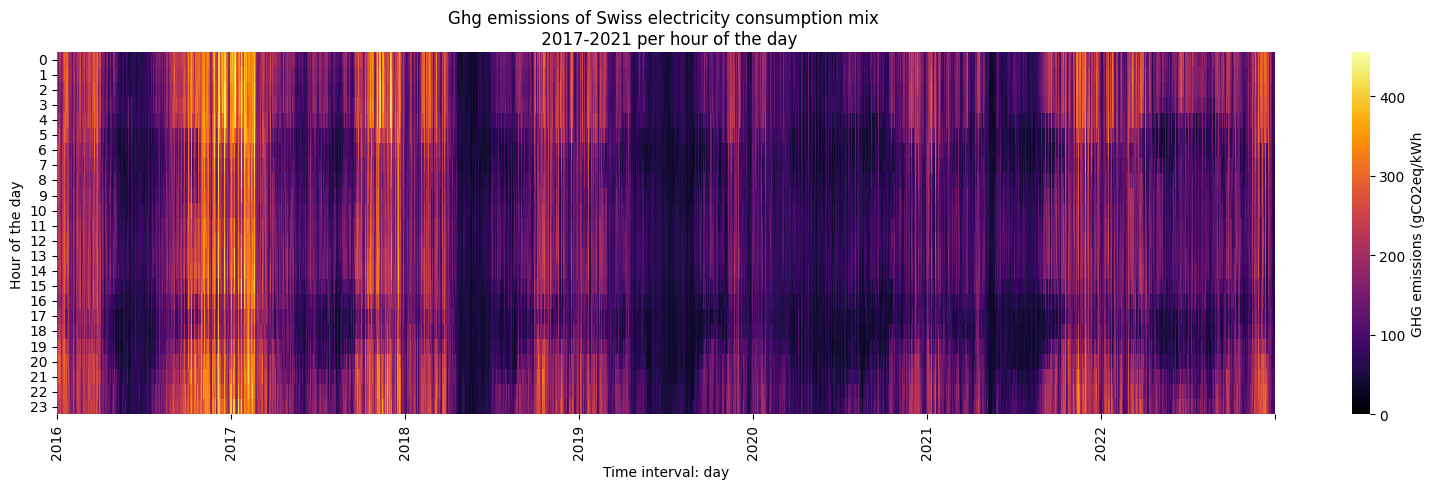

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
# Heatmap import
data = electricity_impact['df'][['sum']].copy()
val_mean = data['sum'].loc['2021-01-01':'2021-12-31'].mean()
#data = (data - val_mean) / val_mean * 100
val_min = -100
val_max = 300
val_min = data.min().min()
val_max = data.max().max()
series = data['sum']
xlabels = list(series.resample('Y').mean().index.map(lambda x: x.year).values)
plot_hourly_heatmap(data, 'sum', xlabels,
                    'Ghg emissions of Swiss electricity consumption mix \n 2017-2021', 'GHG emissions (gCO2eq/kWh',
                    val_min=val_min,
                    val_max=val_max, fig=fig, ax=ax, cmap='inferno')
fig.tight_layout()

Yearly average of carbon emissions per consumed kWh :
**Warning** the data before 2020 is mis-estimated because of the lack of knowledge on the composition of the residual

In [26]:
yearly_mean = producing_electricity_impact['df'][['sum']].groupby(producing_electricity_impact['df'].index.year).mean()
yearly_mean

,sum
2016,11.672916
2017,12.561092
2018,13.190943
2019,14.408879
2020,14.185810
2021,13.759773
2022,13.962184


In [27]:
yearly_mean = electricity_impact['df'][['sum']].groupby(electricity_impact['df'].index.year).mean()
yearly_mean

,sum
2016,170.865282
2017,177.874491
2018,128.227385
2019,98.477391
2020,87.807121
2021,118.784520
2022,136.310679


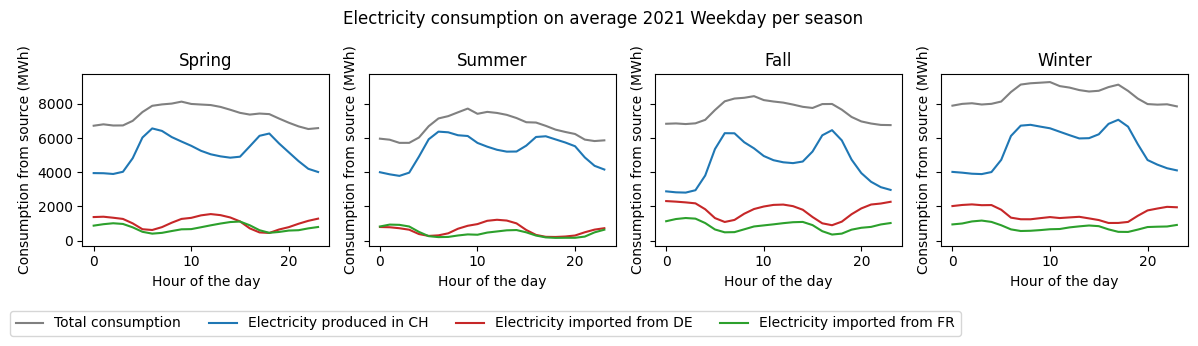

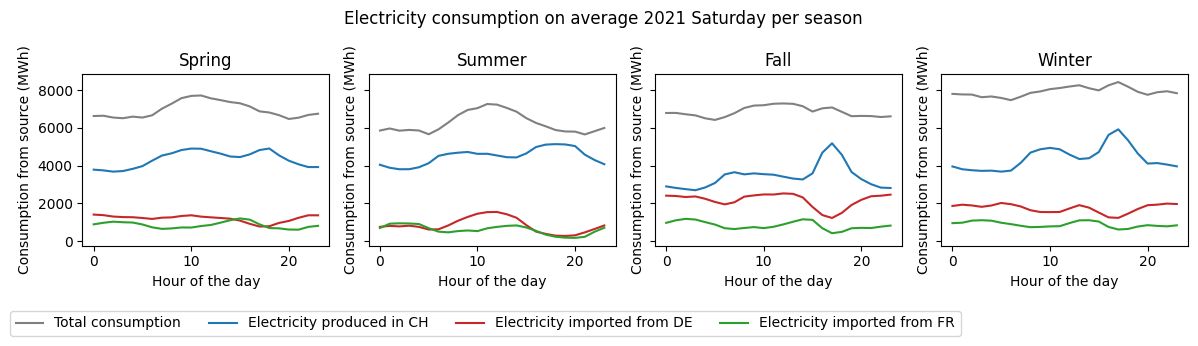

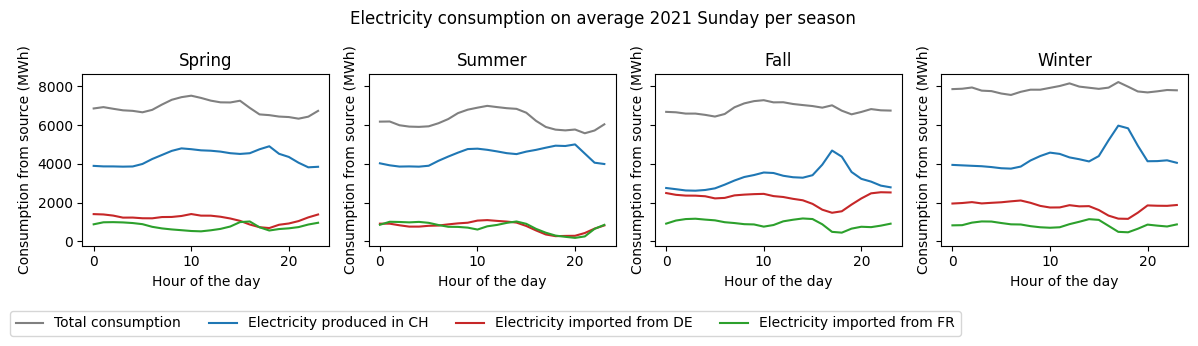

In [28]:
countries = ['sum', 'CH', 'DE', 'FR']
start = '2021-01-01'
end = '2021-12-31'
years_label = '2021'
data = raw_consumption_by_src['df'][countries].loc[start:end].copy()

season_names = {2: 'Spring', 3: 'Summer', 4: 'Fall', 1: 'Winter'}
data['Season'] = [date.month % 12 // 3 + 1 for date in data.index]
data['Season'] = data['Season'].map(season_names)
data['DayOfWeek'] = [0 if date.weekday() < 5 else 1 if date.weekday() == 5 else 2 for date in data.index]
grouped_data = data.groupby('Season')

season_labels = [*season_names.values()]
weekdays = ['Weekday', 'Saturday', 'Sunday']
for k in range(len(weekdays)):
    fig, ax = plt.subplots(1, len(season_labels), sharey=True, figsize=(12, 3))
    for i in range(4):
        seasonal_data = [grouped_data.get_group(season) for season in season_labels]
        seasonal_data = [s[s['DayOfWeek'] == k][data.columns[i]] for s in seasonal_data]
        plot_typical_days(seasonal_data, season_labels,
                          f'Electricity consumption on average {years_label} {weekdays[k]}',
                          'Consumption from source (MWh)',
                          fig=fig, ax=ax)
    for i in range(len(season_labels)):
        for j in range(len(ax[i].get_lines())):
            ax[i].get_lines()[j].set_color(colormap[countries[j]])
    fig.legend(['Total consumption', 'Electricity produced in CH', 'Electricity imported from DE',
                'Electricity imported from FR'], loc='upper left', ncol=4, bbox_to_anchor=(0, 0))
    plt.show()

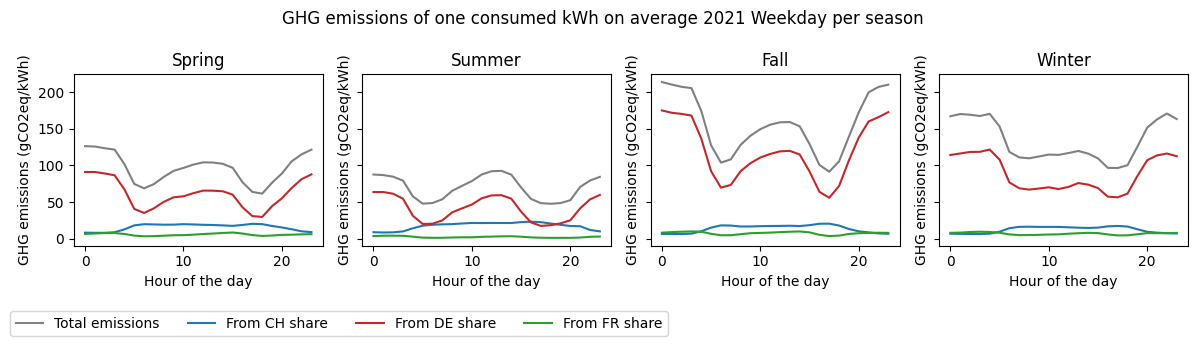

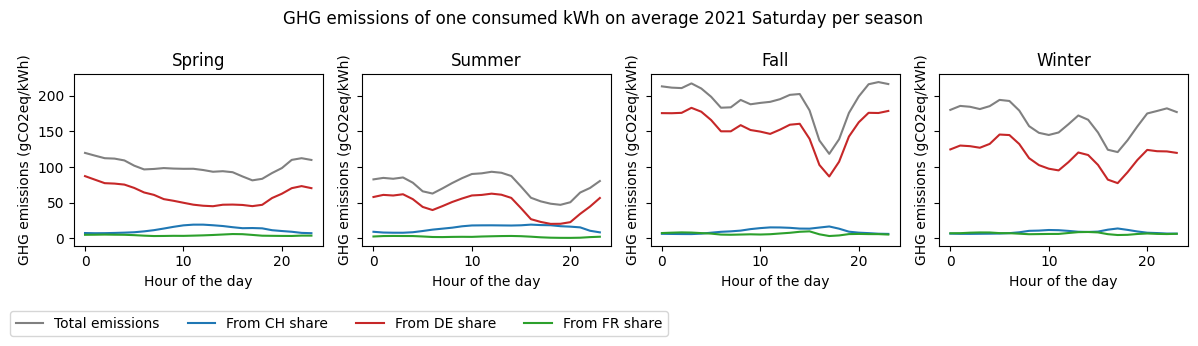

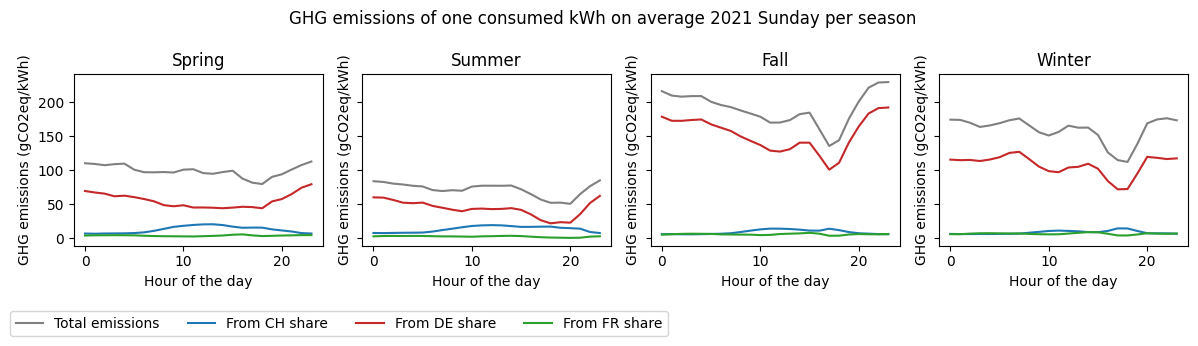

In [29]:
data = electricity_impact['df'][countries].loc[start:end].copy()
data['Season'] = [date.month % 12 // 3 + 1 for date in data.index]
data['Season'] = data['Season'].map(season_names)
data['DayOfWeek'] = [0 if date.weekday() < 5 else 1 if date.weekday() == 5 else 2 for date in data.index]
grouped_data = data.groupby('Season')

for k in range(len(weekdays)):
    fig, ax = plt.subplots(1, len(season_labels), sharey=True, figsize=(12, 3))
    for i in range(4):
        seasonal_data = [grouped_data.get_group(season) for season in season_labels]
        seasonal_data = [s[s['DayOfWeek'] == k][data.columns[i]] for s in seasonal_data]
        plot_typical_days(seasonal_data, season_labels,
                          f'GHG emissions of one consumed kWh on average {years_label} {weekdays[k]}',
                          'GHG emissions (gCO2eq/kWh)',
                          fig=fig, ax=ax)
    for i in range(len(season_labels)):
        for j in range(len(ax[i].get_lines())):
            ax[i].get_lines()[j].set_color(colormap[countries[j]])
    fig.legend(['Total emissions', 'From CH share', 'From DE share', 'From FR share'], loc='upper left', ncol=4,
               bbox_to_anchor=(0, 0))
    plt.show()

-- The end --